# GeoPre Library Example Usage
### This notebook demonstrates key features of the GeoPre library for geospatial data processing.

## 1. Installation and Imports
### Install dependencies if needed
### !pip install geopandas rasterio xarray rioxarray pyproj numpy matplotlib

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from GeoPre import *

## 2. Data Scaling Examples

In [2]:
# Load vector data
vector_data = gpd.read_file("/PATH/TO/Municipalities_on_lakes.shp")
# Open raster file
with rasterio.open("/PATH/TO/l8monzaali.tif") as src:
    # Read raster data as numpy array
    raster_array = src.read(1)  # Read first band
    profile = src.profile

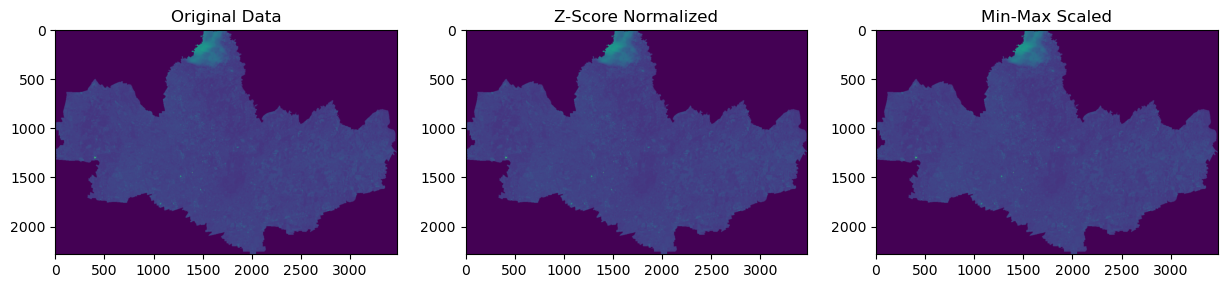

In [3]:
# Apply scaling
z_normalized = Z_score_scaling(raster_array)
minmax_scaled = Min_Max_Scaling(raster_array)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(raster_array, cmap='viridis')
ax1.set_title('Original Data')
ax2.imshow(z_normalized, cmap='viridis')
ax2.set_title('Z-Score Normalized')
ax3.imshow(minmax_scaled, cmap='viridis')
ax3.set_title('Min-Max Scaled')
plt.show()

## 3. CRS Management Workflow

In [4]:
raster_data = rasterio.open('/PATH/TO/NE1_50M_SR_W.tif')
vector = gpd.read_file("/PATH/TO/Municipalities_on_lakes.shp")

In [5]:
# Get CRS information
print("Vector CRS:", get_crs(vector_data))
print("Raster CRS:", get_crs(raster_data))

Vector CRS: EPSG:32632
Raster CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [6]:
# Compare CRS
crs_comparison = compare_crs(raster_data, vector_data)
print("\nCRS Comparison Results:")
for k, v in crs_comparison.items():
    print(f"{k:>10}: {v}")


CRS Comparison Results:
raster_crs: EPSG:4326
vector_crs: EPSG:32632
  same_crs: False
     error: None


## 4. Reprojection Example

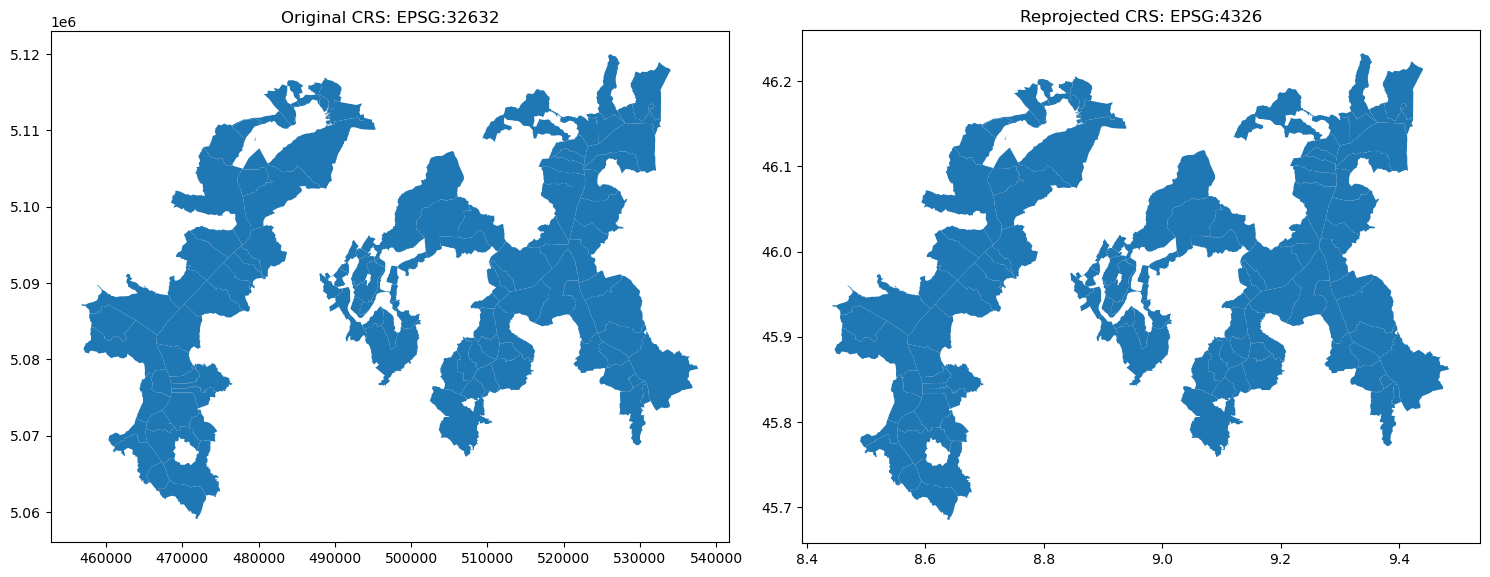

In [7]:
if not crs_comparison["same_crs"]:
    # Reproject vector data to match raster CRS
    reprojected_vector = reproject_data(vector_data, target_crs=crs_comparison["raster_crs"])
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    vector_data.plot(ax=ax1, legend=True)
    ax1.set_title(f'Original CRS: {crs_comparison["vector_crs"]}')
    reprojected_vector.plot(ax=ax2, legend=True)
    ax2.set_title(f'Reprojected CRS: {crs_comparison["raster_crs"]}')
    plt.tight_layout()
    plt.show()

## 5. No-Data Masking Example

In [8]:
# Create sample raster with no-data values
masked_array = raster_data.read(1)
masked_array[1000:1500, 7000:7500] = 255  # Set no-data region

In [9]:
# Apply masking
masked_data, mask, profile = mask_raster_data(
    masked_array,
    profile=raster_data.profile,
    no_data_value=255,
    return_mask=True
)

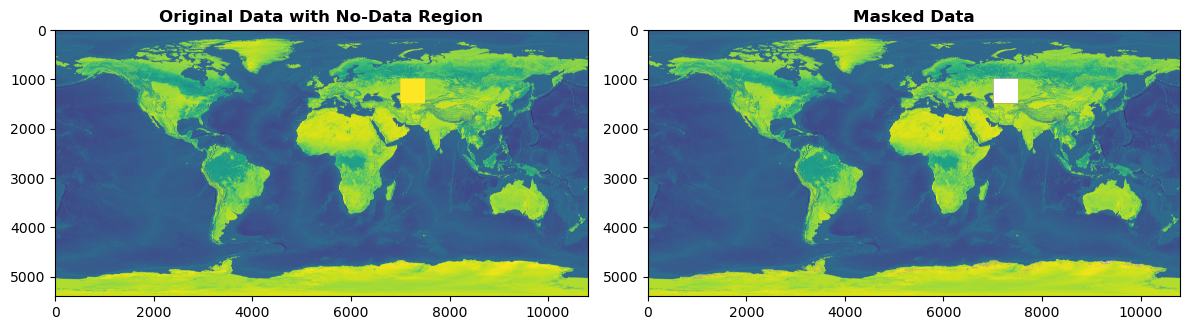

In [10]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
show(masked_array, ax=ax1, cmap='viridis', title='Original Data with No-Data Region')
show(masked_data, ax=ax2, cmap='viridis', title='Masked Data')
plt.tight_layout()
plt.show()


## 6. Multi-Band Raster usage example

In [11]:
# 1. Read and process data while keeping file open
with rasterio.open("/PATH/TO/MILAN.tif") as src:
    # Read all bands (3D array: bands x height x width)
    raster_array = src.read()
    original_profile = src.profile.copy()
    
    # 2. Process bands while file is open
    # Mask NoData values
    masked_data, mask, profile = mask_raster_data(
        raster_array, 
        profile=original_profile,
        no_data_value= 0,
        return_mask=True
    )
    
    # Band-wise scaling
    processed_bands = np.stack([
        Z_score_scaling(band.filled(np.nan)) 
        for band in masked_data
    ], axis=0)

    # 3. Reproject while file is still open
    reprojected_array, new_profile = reproject_data(
        src,  # Use OPEN DatasetReader
        target_crs="EPSG:4326"
    )

# 4. Save results AFTER closing original file
new_profile.update({
    'count': reprojected_array.shape[0],
    'dtype': 'float32',
    'nodata': np.nan
})

with rasterio.open('MILAN_output.tif', 'w', **new_profile) as dst:
    dst.write(reprojected_array)